# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. Нам необходимо построить модель для определения стоимости. 
В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.
<br> <br>
Для того, чтобы получить оптимальные предсказания, мы предпримем следующие шаги:<br>
1. Изучим данные и сделаем предобработку.
2. Подготовим данные для использования моделями - проанализируем признаки и удалим неинформативные.
3. Обучим различные модели.
4. Выберем оптимальную модель и подберем оптимальные гиперпараметры с учетом требования заказчика (см.выше).


## Подготовка данных

In [1]:
#импорт библиотек
import time

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [2]:
State = 12345

In [3]:
# загрузка данных и обзор первых строк
data = pd.read_csv('/datasets/autos.csv')
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [5]:
data.describe(include = 'all')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
count,354369,354369.000000,316879,354369.000000,334536,354369.000000,334664,354369.000000,354369.000000,321474,354369,283215,354369,354369.0,354369.000000,354369
unique,271174,NaN,8,NaN,2,NaN,250,NaN,NaN,7,40,2,109,NaN,NaN,179150
top,2016-03-24 14:49:47,NaN,sedan,NaN,manual,NaN,golf,NaN,NaN,petrol,volkswagen,no,2016-04-03 00:00:00,NaN,NaN,2016-04-06 13:45:54
freq,7,NaN,91457,NaN,268251,NaN,29232,NaN,NaN,216352,77013,247161,13719,NaN,NaN,17
mean,NaN,4416.656776,NaN,2004.234448,NaN,110.094337,NaN,128211.172535,5.714645,NaN,NaN,NaN,NaN,0.0,50508.689087,NaN
std,NaN,4514.158514,NaN,90.227958,NaN,189.850405,NaN,37905.341530,3.726421,NaN,NaN,NaN,NaN,0.0,25783.096248,NaN
min,NaN,0.000000,NaN,1000.000000,NaN,0.000000,NaN,5000.000000,0.000000,NaN,NaN,NaN,NaN,0.0,1067.000000,NaN
25%,NaN,1050.000000,NaN,1999.000000,NaN,69.000000,NaN,125000.000000,3.000000,NaN,NaN,NaN,NaN,0.0,30165.000000,NaN
50%,NaN,2700.000000,NaN,2003.000000,NaN,105.000000,NaN,150000.000000,6.000000,NaN,NaN,NaN,NaN,0.0,49413.000000,NaN
75%,NaN,6400.000000,NaN,2008.000000,NaN,143.000000,NaN,150000.000000,9.000000,NaN,NaN,NaN,NaN,0.0,71083.000000,NaN


Предварительные выводы, которые мы можем сделать по этим данным: <br>
1. Столбцы Price, Power, Registration Month содержат нулевые значения, хотя по содержанию эти признаки не могут быть нулевыми. Необходимо посмотреть подробнее каждый набор строк с нулевыми значениями.
2. Столбец Registration Year содержит аномальные значения - как минимум, это значения 1000 и 9999, но возможно есть и еще другие аномалии. Необходимо исследовать этот столбец.
3. Столбец Power содержит аномально высокое значение - 20 000, возможно, оно не является единственной аномалией.
4. Столбец Number of Pictures не информативен, т.к. во всех строках указано одно и то же значение - 0. От него можно избавиться.
5. Столбец Postal Code содержит в себе 4-хзначные и 5-тизначные индексы, что соответствует разным странам происхождения внутри Европы. 
6. В столбце Fuel type мы видим встречающиеся значения petrol & gasoline, что является синонимами. Чтобы не запутывать алгоритм, лучше оставить только одно написание.
7. Есть пропущенные значения в столбцах с категориальными признаками. Лучше исследовать их и, при необходимости, заполнить или удалить.

### Подготовка данных

Приведем названия столбцов к snake_case.

In [6]:
data.rename(columns = {'DateCrawled' : 'date_crawled', 
                       'VehicleType': 'vehicle_type', 
                       'RegistrationYear':'registration_year',
                       'RegistrationMonth': 'registration_month', 
                       'FuelType': 'fuel_type',
                       'NotRepaired': 'not_repaired', 
                       'DateCreated': 'date_created',
                       'NumberOfPictures': 'number_of_pictures', 
                       'PostalCode': 'postal_code', 
                       'LastSeen': 'last_seen'}, inplace = True)
data.columns = data.columns.str.lower()

Посмотрим значения в категориальных столбцах Vehicle type, Fuel type, Gearbox, Model, Brand.

In [7]:
cat_col = ['vehicle_type', 'model', 'brand', 'gearbox', 'fuel_type', 'repaired']
for column in cat_col:
    display(data[column].value_counts())

sedan          91457
small          79831
wagon          65166
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: vehicle_type, dtype: int64

golf                  29232
other                 24421
3er                   19761
polo                  13066
corsa                 12570
                      ...  
serie_2                   8
rangerover                4
serie_3                   4
serie_1                   2
range_rover_evoque        2
Name: model, Length: 250, dtype: int64

volkswagen        77013
opel              39931
bmw               36914
mercedes_benz     32046
audi              29456
ford              25179
renault           17927
peugeot           10998
fiat               9643
seat               6907
mazda              5615
skoda              5500
smart              5246
citroen            5148
nissan             4941
toyota             4606
hyundai            3587
sonstige_autos     3374
volvo              3210
mini               3202
mitsubishi         3022
honda              2817
kia                2465
suzuki             2323
alfa_romeo         2314
chevrolet          1754
chrysler           1439
dacia               900
daihatsu            806
subaru              762
porsche             758
jeep                677
trabant             589
land_rover          545
daewoo              542
saab                526
jaguar              505
rover               486
lancia              471
lada                225
Name: brand, dtype: int64

manual    268251
auto       66285
Name: gearbox, dtype: int64

petrol      216352
gasoline     98720
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: fuel_type, dtype: int64

no     247161
yes     36054
Name: repaired, dtype: int64

Значения в категориальных столбцах выглядят вполне адекватно. Можем заменить 'gasoline' на 'petrol' в столбце Fuel type, т.к. это одно и то же.

In [8]:
data[data['model']=='golf']['vehicle_type'].unique()

array([nan, 'small', 'sedan', 'bus', 'other', 'wagon', 'convertible',
       'coupe', 'suv'], dtype=object)

In [9]:
data['fuel_type'] = data['fuel_type'].replace(to_replace ='gasoline', value ='petrol')

Можем удалить столбец Number of pictures, т.к. он заполнен нулями и не несет никакой практической ценности.

In [10]:
data = data.drop('number_of_pictures', axis =1)

### Предобработка данных

Необходимо предобработать данные для последующего использования в модели - убрать Nan'ы, изучить выбросы и аномалии.

In [13]:
#обработка Nan
nan_col = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'repaired']
for column in nan_col:
    print(f'В столбце {column} количество пропусков: {(data[column].isna()).sum()}, это {(data[column].isna()).sum()/len(data): 0.01%} от общего числа строк')

В столбце vehicle_type количество пропусков: 37490, это  10.6% от общего числа строк
В столбце gearbox количество пропусков: 19833, это  5.6% от общего числа строк
В столбце model количество пропусков: 19705, это  5.6% от общего числа строк
В столбце fuel_type количество пропусков: 32895, это  9.3% от общего числа строк
В столбце repaired количество пропусков: 71154, это  20.1% от общего числа строк


Количество пропусков достаточно большое в каждом случае (более 5%). Однако в случае с model мы вынуждены удалить эти строки, т.к. они имеют критическое значение при сравнительно небольшом количестве, а восстановить название моделей по остальным характеристикам невозможно. <br>
В столбце not_repaired 20% незаполненных значений, их так же нельзя удалять, но мы можем предположить, что они не были заполнены там, где ремонт не проводился (значение 'no'), и можем заполнить этим значением Nan'ы. <br>
По столбцу fuel_type можно применить в качестве замены наиболее популярное - petrol, т.к. большинство автомобилей имеют ДВС-двигатель. Но можно предварительно проверить, не встречается ли среди этих моделей движков с LPG, CNG или гибридов/EV. <br>
Столбец vehicle_type требует более детального изучения, а вот строки с nan в столбце gearbox придется удалить - восстановить их нет никакой возможности.

In [14]:
#удаление строк с пропусками в столбцах model, gearbox
data= data.dropna(subset = ['model', 'gearbox', 'vehicle_type'])
# замена nan в столбце not_repaired
data['not_repaired'] = data['repaired'].fillna('no')
data['fuel_type'].fillna('not_indicated', inplace = True)

/tmp/ipykernel_133/3658287587.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['not_repaired'] = data['repaired'].fillna('no')
/opt/conda/lib/python3.9/site-packages/pandas/core/series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


Столбцы с датой создания объявления, датой выгрузки и последнего визита на сайт, а также с месяцем регистрации автомобиля не несут никакой практической пользы для модели, т.к. эти вводные не имеют прямой корреляции с ценой, это техническая информация. Можно удалить эти столбцы. <br>
Почтовые коды следует оставить - поскольку есть пятизначные и четырехзначные варианты, это означает, что автовладельцы находятся в разных странах. Цены на одни и те же автомобили могут различаться в зависимости от страны, поэтому почтовый индекс может напрямую влиять на прогнозирование. Но необходимо перевести его в формат строки, чтобы алгоритм не обрабатывал код как число.

In [15]:
data = data.drop(['date_crawled', 'registration_month', 'date_created', 'last_seen', 'postal_code'], axis =1)
#data['postal_code'] = data['postal_code'].astype('object')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 295258 entries, 2 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              295258 non-null  int64 
 1   vehicle_type       295258 non-null  object
 2   registration_year  295258 non-null  int64 
 3   gearbox            295258 non-null  object
 4   power              295258 non-null  int64 
 5   model              295258 non-null  object
 6   kilometer          295258 non-null  int64 
 7   fuel_type          295258 non-null  object
 8   brand              295258 non-null  object
 9   repaired           252918 non-null  object
 10  not_repaired       295258 non-null  object
dtypes: int64(4), object(7)
memory usage: 27.0+ MB


Теперь изучим аномалии, выявленные в ходе первичного скрининга данных: столбцы price, registration_year & power.

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired,not_repaired


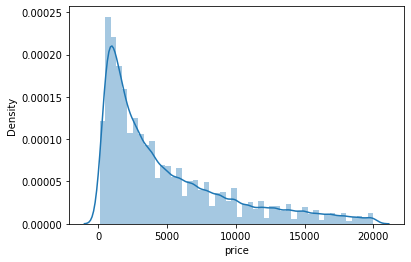

In [18]:
# price

sns.distplot(data['price']);
data[data['price']<100]


Автомобили с ценой менее 100 евро - это либо исключения, либо аномалии, связанные с неправильным заполнением ячейки с ценой (среди них мы видимо относительно новые автомобили - с годом выпуска после 2000). Удалим их.

In [17]:
data = data[data['price']>100]

count    295258.000000
mean       2002.461908
std           6.255705
min        1910.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2018.000000
Name: registration_year, dtype: float64

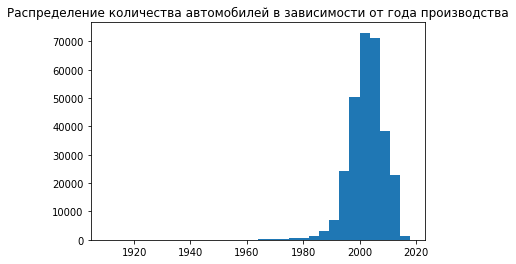

In [16]:
# registration_year
data['registration_year'].hist(bins=30, grid = False)
plt.title('Распределение количества автомобилей в зависимости от года производства');
data['registration_year'].describe()

Мы видим, что значения распределены нормально, хотя есть определенные выбросы - автомобили старше 1960 года. Таких строк не так много, и можно смело избавиться от них.

In [19]:
data = data[(data['registration_year']>1960) & (data['registration_year']< 2016)]

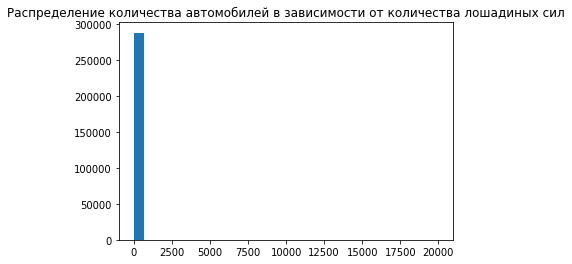

In [20]:
# power
data['power'].hist(bins=30, grid = False)
plt.title('Распределение количества автомобилей в зависимости от количества лошадиных сил');

Мы видим, что абсолютное большинство значений лежит в промежутке от 0 до 500 л.с. Выбросы свыше этой величины можно смело отбросить. <br>
В то же время, есть нулевые значения в столбце power. 

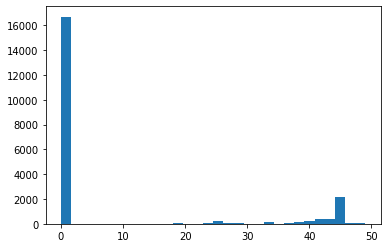

In [21]:
data[data['power']<50]['power'].hist(bins = 30, grid = False);

Более 17500 строк с нулевым и близким к нулю значением мощности двигателя! Это явная ошибка. К сожалению, заменить нулевые значения на какие-либо другие нельзя, т.к. даже у одной той же модели силовые агрегаты могут различаться по мощности. Придется удалить их.

In [22]:
data = data.loc[(data['power']<500) &(data['power']>0)]

Данные предобработаны. Мы избавились от Nan'ов, аномальных значений в строках, а также от столбцов, не несущих смысловой нагрузки для последующего обучения. Посмотрим теперь, какова корреляция между числовыми столбцами и целевым признаком, а также - внутри признаков (чтобы исключить взаимозависимость).

In [ ]:
data.corr().style.background_gradient(axis=None, vmin=0, vmax=1, cmap="YlGnBu")

Мы видим, что есть прямая корреляция между признаками registration_year и power и целевым признаком, а также небольшая обратная корреляция между целевым признаком и столбцом kilometer. Внутри признаков особенной корреляции не наблюдается. <br>
Датасет готов, можно переходить к обучению моделей.

## Обучение моделей

Наша задача - предсказать числовой признак "Price" при помощи обучения различных моделей. Среди признаков есть как категориальные, так и числовые переменные. Для наших целей подойдут модели линейной регрессии и бустинга. <br>
Мы будем следовать следующему порядку действий:
1. разделим датасет на признаки и целевой признак
2. подготовим признаки для последующего использования в моделях - закодируем категориальные признаки, затем масштабируем.
3. разделим датасет на обучающий, валидационный и тестовый
4. обучим модели LightGBM, CatBoost, LinearRegression, DecisionTree и подберем для каждой оптимальные параметры. <br>
Эти обученные модели мы впоследствии сравним между собой по ряду критериев - быстродействие, точность предсказаний, скорость обучения.

In [23]:
# разделение на признаки и таргет
features = data.drop('price', axis =1)
target = data['price']
# OHE-кодирование категориальных признаков для бустинговых моделей
categorial = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'not_repaired']
features_ohe = pd.get_dummies(features[categorial], drop_first = False)
features_ohe = features_ohe.merge(features[['kilometer', 'power', 'registration_year']], 
                                  how = 'left', 
                                  left_index = True, 
                                  right_index = True)
# разделение на трейновую, валидационную и тестовую выборки
features_trainval_ohe, features_test_ohe, target_trainval_ohe, target_test_ohe = train_test_split(features_ohe, 
                                                                                                  target, 
                                                                                                  test_size = 0.2, 
                                                                                                  random_state = State)
features_train_ohe, features_valid_ohe, target_train_ohe, target_valid_ohe = train_test_split(features_trainval_ohe, 
                                                                                              target_trainval_ohe, 
                                                                                              test_size =0.25, 
                                                                                              random_state = State)

# масштабирование признаков
columns = features_ohe.columns
scaler_ohe = StandardScaler()
scaler_ohe.fit(features_ohe)
features_train_ohe = pd.DataFrame(scaler_ohe.transform(features_train_ohe), columns = columns)
features_trainval_ohe = pd.DataFrame(scaler_ohe.transform(features_trainval_ohe), columns = columns)
features_valid_ohe = pd.DataFrame(scaler_ohe.transform(features_valid_ohe), columns = columns)
features_test_ohe = pd.DataFrame(scaler_ohe.transform(features_test_ohe), columns = columns)



In [24]:
# Ordinal Encoding для Random Forest и Decision Tree
encoder = OrdinalEncoder()
encoder.fit(features[categorial])
features_ord_1 = encoder.transform(features[categorial])
features_ord = pd.DataFrame(features_ord_1, columns = features[categorial].columns)
features_ord = features_ord.merge(features[['kilometer', 'power', 'registration_year']].reset_index(drop = True), 
                                  how = 'left', 
                                  left_index = True, 
                                  right_index = True)
# разделение на трейновую, валидационную и тестовую выборки
features_trainval_ord, features_test_ord, target_trainval_ord, target_test_ord = train_test_split(features_ord, target, test_size = 0.2, random_state = State)
features_train_ord, features_valid_ord, target_train_ord, target_valid_ord = train_test_split(features_trainval_ord, target_trainval_ord, test_size =0.25, random_state = State)

# масштабирование признаков
columns = features_ord.columns
scaler_ord = StandardScaler()
scaler_ord.fit(features_ord)
features_train_ord = pd.DataFrame(scaler_ord.transform(features_train_ord), columns = columns)
features_trainval_ord = pd.DataFrame(scaler_ord.transform(features_trainval_ord), columns = columns)
features_valid_ord = pd.DataFrame(scaler_ord.transform(features_valid_ord), columns = columns)
features_test_ord = pd.DataFrame(scaler_ord.transform(features_test_ord), columns = columns)

Создадим функцию, которая будет обучать модель, регистрируя попутно тайминг обучения, а затем будет делать предсказания на валидационном датасете, также попутно регистрируя время. Функция возвращает значения времени в секундах, а также значение самого RMSE. Нам пригодятся эти параметры, чтобы сделать сравнение моделей.

In [25]:
def train_and_predict(model, features_train, target_train, features_valid, target_valid):
    # вычисление времени на обучение
    start_fit = time.time()
    model.fit(features_train, target_train)
    end_fit = time.time()
    time_fit = round((end_fit - start_fit), 4)
    # вычисление времени на предсказание
    start_predict = time.time()
    predictions = model.predict(features_valid)
    end_predict = time.time()
    time_predict = round((end_predict - start_predict), 4)
    # вычисление RMSE
    rmse = round(mean_squared_error(target_valid, predictions)**0.5, 2)
    return time_fit, time_predict, rmse

Создадим шаблон таблицы, куда будем складывать результаты по каждому из ключевых критериев для каждой модели.

In [26]:
model_list = ['Constant', 'DecisionTree', 'RandomForest', 'GradientBoosting', 'CatBoost', 'LightGBM']
col_names = ['Time-to-fit', 'Time-to-predict', 'RMSE']
table= pd.DataFrame(columns = col_names, index = model_list)

Теперь можем приступать к сравнению моделей. Для начала создадим заглушку - константную модель, которая заполняет все значения средним значением по датасету, и посчитаем ее RMSE. В дальнейшем будем сравнивать наши модели с ее результатом.

**Константная модель**

In [27]:
dummy_model = DummyRegressor(strategy ='mean')
result = train_and_predict(dummy_model, features_train_ohe, target_train_ohe, features_valid_ohe, target_valid_ohe)
table.loc['Constant', 'Time-to-fit'] = result[0]
table.loc['Constant', 'Time-to-predict'] = result[1]
table.loc['Constant', 'RMSE'] = result[2]

**LightGBM**

In [28]:
model_LGB = LGBMRegressor(force_col_wise=True, num_iterations = 100, verbosity = 0, random_state = State)
result = train_and_predict(model_LGB, features_train_ohe, target_train_ohe, features_valid_ohe, target_valid_ohe)
table.loc['LightGBM', 'Time-to-fit'] = result[0]
table.loc['LightGBM', 'Time-to-predict'] = result[1]
table.loc['LightGBM', 'RMSE'] = result[2]

/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


**Decision Tree**

In [ ]:
model_DTR = DecisionTreeRegressor(random_state = State)
result = train_and_predict(model_DTR, features_train_ord, target_train_ord, features_valid_ord, target_valid_ord)
table.loc['DecisionTree', 'Time-to-fit'] = result[0]
table.loc['DecisionTree', 'Time-to-predict'] = result[1]
table.loc['DecisionTree', 'RMSE'] = result[2]

**Random Forest**

In [ ]:
model_RFR = RandomForestRegressor(random_state = State)
result = train_and_predict(model_RFR, features_train_ord, target_train_ord, features_valid_ord, target_valid_ord)
table.loc['RandomForest', 'Time-to-fit'] = result[0]
table.loc['RandomForest', 'Time-to-predict'] = result[1]
table.loc['RandomForest', 'RMSE'] = result[2]

**Gradient Boost**

In [ ]:
model_GBR = GradientBoostingRegressor(random_state = State)
result = train_and_predict(model_GBR, features_train_ohe, target_train_ohe, features_valid_ohe, target_valid_ohe)
table.loc['GradientBoosting', 'Time-to-fit'] = result[0]
table.loc['GradientBoosting', 'Time-to-predict'] = result[1]
table.loc['GradientBoosting', 'RMSE'] = result[2]

**CatBoost**

In [ ]:
model_CB = CatBoostRegressor(verbose = False, random_state = State)
result = train_and_predict(model_CB, features_train_ohe, target_train_ohe, features_valid_ohe, target_valid_ohe)
table.loc['CatBoost', 'Time-to-fit'] = result[0]
table.loc['CatBoost', 'Time-to-predict'] = result[1]
table.loc['CatBoost', 'RMSE'] = result[2]

## Анализ моделей и тестирование лучшей модели

Мы собрали данные по всем моделям в таблицу и теперь можем проанализировать результаты.

In [29]:
table

,Time-to-fit,Time-to-predict,RMSE
Constant,0.0008,0.0003,4633.52
DecisionTree,NaN,NaN,NaN
RandomForest,NaN,NaN,NaN
GradientBoosting,NaN,NaN,NaN
CatBoost,NaN,NaN,NaN
LightGBM,378.3567,0.8945,1631.05


Мы обучили модели и получили в итоге сравнительную таблицу с ключевами параметрами: время обучения, время предсказания и RMSE. <br>
Исходя из таблицы, мы видим, что максимально эффективной, с учетом всех трех параметров, является CatBoost, ее время обработки в разы отличается от времени, затрачиваемого другими бустингами, и RMSE тоже более низкий. Аналогичный RMSE и время обучения показывает Random Forest, но время обучения в 20 раз выше, поэтому мы делаем выбор в пользу CatBoost. <br> 
В этой главе мы подберем для нее наилучшие параметры, и протестируем на тестовой выборке с условием RMSE не больше 2500.

In [ ]:
# настроим гиперпараметры модели
# 1.learning rate
best_rmse = table.loc['CatBoost', 'RMSE']
best_time = table.loc['CatBoost', 'Time-to-fit']
best_rate = 0.1
for rate in np.arange(0.1, 0.85, 0.1):
    model_CB = CatBoostRegressor(verbose = False, learning_rate = rate, random_state = State)
    result = train_and_predict(model_CB, features_train_ohe, target_train_ohe, features_valid_ohe, target_valid_ohe)
    print(f'Модель CB с темпом обучения {round(rate,2)} обучается {result[0]}c и дает RMSE {result[2]}')
    if result[2]< best_rmse:
        best_rate = rate
        best_rmse = result[2]
        
# 2. tree depth      
best_depth = 6
for depth in range(4, 10):
    model_CB = CatBoostRegressor(verbose = False, learning_rate = best_rate, depth = depth, random_state = State)
    result = train_and_predict(model_CB, features_train_ohe, target_train_ohe, features_valid_ohe, target_valid_ohe)
    print(f'Модель CB с глубиной {depth} обучается {result[0]}c и дает RMSE {result[2]}')
    if result[2]< best_rmse:
        best_depth = depth
        best_rmse = result[2]
        
# 3. L2 regularisation
best_l2 = 3
for l2 in range(1,8, 2):
    model_CB = CatBoostRegressor(verbose = False, learning_rate = best_rate, depth=best_depth, l2_leaf_reg = l2, random_state = State)
    result = train_and_predict(model_CB, features_train_ohe, target_train_ohe, features_valid_ohe, target_valid_ohe)
    print(f'Модель CB с уровнем регуляризации {l2} обучается {result[0]}c и дает RMSE {result[2]}')
    if result[2]< best_rmse:
        best_l2 = l2
        best_rmse = result[2]

## Тестирование лучшей модели

In [ ]:
print('Хорошие показатели дает следующая комбинация гиперпараметров:')
print(f'Best learning rate: {best_rate}')
print(f'Best depth: {best_depth}')
print(f'Best L2: {best_l2}')

Проверим модель на тестовой выборке. RMSE должен быть не ниже 2500.

In [ ]:
final_model = CatBoostRegressor(learning_rate = best_rate, 
                       depth=best_depth, 
                       l2_leaf_reg = best_l2, 
                       verbose = False, 
                       random_state = State)
final_model.fit(features_trainval_ohe, target_trainval_ohe)
print(f'RMSE на модели с оптимизированными гиперпараметрами: {round(mean_squared_error(target_test_ohe, final_model.predict(features_test_ohe))**0.5, 2)}')


**Вывод** <br>
Мы проанализировали и предобработали данные таким образом, чтобы оптимизировать используемую в модели информацию. <br>
Нам удалось подобрать оптимальную модель с учетом требований заказчика, это модель CatBoost. Ее среднее время обучения менее 30 секунд, тогда как другие бустинговые модели требуют не менее минуты. Быстро обучается также модель Random Forest, но ее RMSE намного выше, чем у CatBoost. <br>
Мы подобрали гиперпараметры модели и достигли RMSE 1473 на тестовой выборке, что является очень хорошим результатом при требовании заказчика не более 2500.